# Experimental  of Physical Therapy Dataset

## Imports + Data

In [3]:
import os
import sys

# Add parent folder to sys.path
sys.path.append(os.path.abspath(".."))
from functools import reduce

import math
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from helpers.load_data import load_and_merge_sensors
from helpers.filtering import preprocess_sensor_data
from helpers.segment import segment_series
import helpers.dtwlabeling

import seglearn as seg
import tensorflow as tf
import sklearn




/Users/hammy/Projects/CS156/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/physical-therapy-exercises-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1


Collecting metadata for template times and subject/exercise/sensor information to use for later

## Data Loading

In [5]:
from helpers.load_data import load_data
df, template_times = load_data(path)

In [6]:
times_sorted = template_times.sort_values(by=['subject', 'exercise']).reset_index().drop('index', axis=1)
times_sorted.head()

,subject,exercise,file_name,path
0,s1,e1,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e2,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e3,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e4,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e5,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [7]:
templates = df[df['file_name'] == 'template_session.txt'].reset_index()
tests = df[df['file_name'] != 'template_session.txt'].reset_index()
templates

,index,subject,exercise,sensor,file_name,path
0,0,s1,e1,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,2,s1,e1,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,4,s1,e1,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,6,s1,e1,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,8,s1,e1,u5,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,390,s5,e8,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,392,s5,e8,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,394,s5,e8,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,396,s5,e8,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [8]:
tests

,index,subject,exercise,sensor,file_name,path
0,1,s1,e1,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,3,s1,e1,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,5,s1,e1,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,7,s1,e1,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,9,s1,e1,u5,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,391,s5,e8,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,393,s5,e8,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,395,s5,e8,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,397,s5,e8,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


## Data Exploration

### Missing Values

## Data Preprocessing and Basic Flow

### Filtering

In [9]:
filtered = []

for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        df = load_and_merge_sensors(templates, subject, exercise)
        filtered.append(preprocess_sensor_data(df))
        
filtered[0]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
time index,,,,,,,,,,,,,,,,,,,,,
1,-0.001333,-0.007595,0.004422,0.004095,-0.001036,-0.002568,0.586987,0.455546,-0.094715,-0.100670,...,-0.003990,-0.006890,0.001793,0.001497,-0.001722,0.015096,0.734998,0.204949,s1,e1
2,0.013005,-0.013095,-0.004900,0.011020,-0.004303,-0.010326,0.587836,0.455185,-0.094108,-0.095614,...,-0.001972,0.004147,-0.000242,0.005843,-0.008403,0.014740,0.735693,0.205079,s1,e1
3,0.022444,-0.011567,-0.012758,0.014666,-0.006443,-0.014997,0.588440,0.454920,-0.093697,-0.092602,...,0.000033,0.011074,-0.002137,0.007792,-0.012732,0.014507,0.736189,0.205166,s1,e1
4,0.026983,-0.003011,-0.019152,0.015034,-0.007456,-0.016579,0.588801,0.454749,-0.093481,-0.091635,...,0.002025,0.013891,-0.003890,0.007343,-0.014711,0.014399,0.736488,0.205211,s1,e1
5,0.026231,0.020488,-0.027197,0.008925,-0.006913,-0.012485,0.588917,0.454674,-0.093460,-0.084545,...,0.005587,0.014358,-0.007949,0.002340,-0.014115,0.014414,0.736588,0.205213,s1,e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,-0.008795,-0.012889,0.036970,-0.000699,-0.003882,-0.002105,0.587366,0.458387,-0.065446,-0.023249,...,-0.010374,0.008147,0.000912,-0.002354,-0.003928,-0.009076,0.726298,0.229593,s1,e1
2184,-0.007871,-0.012657,0.020781,0.000102,-0.004006,-0.003231,0.587438,0.458272,-0.065359,-0.023831,...,-0.007958,0.002685,0.000743,-0.002597,-0.005429,-0.008929,0.726273,0.229721,s1,e1
2185,-0.006279,-0.011436,0.013809,0.000174,-0.003182,-0.003000,0.587482,0.458070,-0.065192,-0.019868,...,-0.006423,0.001110,0.000411,-0.001753,-0.005188,-0.008668,0.726171,0.229997,s1,e1


In [10]:
filtered_df = pd.concat(filtered)
filtered_df.shape

(55325, 47)

### Segmenting

In [17]:
import numpy as np

def create_windows(filtered_df, sensor_cols, window_size=50, stride=25, idle_label=0):
    """
    Create sliding windows from IMU data per subject.
    Returns:
        X_segments: (num_windows, window_size, num_sensors)
        y_segments: (num_windows,)
        subject_windows: array of subject ids per window
    """

    X_segments_list = []
    y_segments_list = []
    subject_windows_list = []

    # Ensure 'exercise' is numeric
    if not np.issubdtype(filtered_df['exercise'].dtype, np.number):
        raise ValueError("'exercise' column must be numeric")

    for subject, df_sub in filtered_df.groupby('subject'):
        X = df_sub[sensor_cols].values
        y_labels = df_sub['exercise'].values

        n_samples, n_sensors = X.shape

        # Slide windows across full timeline (including idle)
        for start in range(0, n_samples - window_size + 1, stride):
            end = start + window_size
            X_window = X[start:end]
            
            # Use center frame label to avoid looking ahead
            center_idx = start + window_size // 2
            y_window = y_labels[center_idx]

            X_segments_list.append(X_window)
            y_segments_list.append(y_window)
            subject_windows_list.append(subject)

    X_segments = np.stack(X_segments_list, axis=0)
    y_segments = np.array(y_segments_list)
    subject_windows = np.array(subject_windows_list)

    return X_segments, y_segments, subject_windows


In [35]:
sensor_cols = [col for col in filtered_df.columns if any(s in col for s in ['acc_', 'gyr_', 'mag_'])]
window_size = 15
stride = 8

X_segments, y_segments, subject_windows = create_windows(
    filtered_df, 
    sensor_cols,
    window_size=window_size,
    stride=stride,
    idle_label=0
)

print(X_segments.shape, y_segments.shape, subject_windows.shape)

(6908, 15, 45) (6908,) (6908,)


### Sample Training

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization, Input

def build_model(window_size, num_sensors, num_classes, use_lstm=False):
    """
    Builds a Keras model for multivariate time-series sensor data.

    Parameters:
    - window_size: int, number of timesteps per window
    - num_sensors: int, number of sensor channels
    - num_classes: int, number of output classes
    - use_lstm: bool, if True adds an LSTM layer after CNN

    Returns:
    - Keras compiled model
    """
    model = Sequential()
    
    # First CNN layer
    model.add(Input(shape=(window_size, num_sensors))),
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Second CNN layer
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    if use_lstm:
        model.add(LSTM(64, return_sequences=False))
    else:
        model.add(Flatten())
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [39]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

subjects = np.unique(subject_windows)
num_classes = len(label_map)  # 8
num_windows, window_size, num_sensors = X_segments.shape

loso_accuracies = []

for test_subject in subjects:
    
    # --------------------------
    # 1. Split windows by subject
    # --------------------------
    train_idx = subject_windows != test_subject
    test_idx = subject_windows == test_subject

    X_train = X_segments[train_idx]
    X_test  = X_segments[test_idx]
    y_train = y_segments[train_idx]
    y_test  = y_segments[test_idx]

    # ------------------------------------
    # 2. Normalize ONLY using TRAINING data
    # ------------------------------------
    scaler = StandardScaler()

    # reshape so scaler sees features as columns
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat  = X_test.reshape(X_test.shape[0],  -1)

    # fit ONLY on training data
    X_train_scaled_flat = scaler.fit_transform(X_train_flat)

    # transform test data using the SAME scaler
    X_test_scaled_flat  = scaler.transform(X_test_flat)

    # reshape back to (num_windows, window_size, num_sensors)
    X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)
    X_test_scaled  = X_test_scaled_flat.reshape(X_test.shape)

    # ------------------------------------
    # 3. Train and evaluate your model
    # ------------------------------------
    y_train_onehot = to_categorical(y_train - 1, num_classes=num_classes)
    y_test_onehot  = to_categorical(y_test - 1,  num_classes=num_classes)

    model = build_model(window_size=X_train.shape[1],
                        num_sensors=X_train.shape[2],
                        num_classes=num_classes)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_scaled, y_train_onehot, epochs=20, batch_size=32, verbose=0)

    loss, acc = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
    print(f"Test subject {test_subject}: accuracy = {acc:.3f}")

    loso_accuracies.append(acc)

print(f"Average LOSO accuracy: {np.mean(loso_accuracies):.3f}")


Test subject s1: accuracy = 0.883
Test subject s2: accuracy = 0.951
Test subject s3: accuracy = 0.843
Test subject s4: accuracy = 0.840
Test subject s5: accuracy = 0.985
Average LOSO accuracy: 0.901


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

subjects = np.unique(filtered_df['subject'].values)
num_classes = len(label_map)  # 8

loso_accuracies = []

for test_subject in np.unique(subject_windows):
    train_idx = subject_windows != test_subject
    test_idx = subject_windows == test_subject

    X_train = X_segments[train_idx]
    y_train = y_segments[train_idx]
    X_test = X_segments[test_idx]
    y_test = y_segments[test_idx]

    # One-hot encode labels
    y_train_onehot = to_categorical(y_train - 1, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test - 1, num_classes=num_classes)

    # Build your model
    model = build_model(window_size=X_train.shape[1], num_sensors=X_train.shape[2], num_classes=num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train_onehot, epochs=20, batch_size=32, verbose=0)

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test_onehot, verbose=0)
    print(f"Test subject {test_subject}: accuracy = {acc:.3f}")
    loso_accuracies.append(acc)

print(f"Average LOSO accuracy: {np.mean(loso_accuracies):.3f}")


/Users/hammy/Projects/CS156/Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test subject s1: accuracy = 1.000
Test subject s2: accuracy = 0.920
Test subject s3: accuracy = 0.979
Test subject s4: accuracy = 0.968
Test subject s5: accuracy = 1.000
Average LOSO accuracy: 0.973


In [ ]:
test_dfs = []
for subject in tests['subject'].unique():
    for exercise in tests['exercise'].unique():
        df = load_and_merge_sensors(tests, subject, exercise)
        test_filter = preprocess_sensor_data(df)
        test_dfs.append(test_filter)

test_dfs = pd.concat(test_dfs)

sensor_cols = [col for col in test_dfs.columns if any(sensor in col for sensor in ['acc_', 'gyr_', 'mag_'])]

test_segments_list = []
y_test_segments_list = []

label_map = {
    'e1': 1,
    'e2': 2,
    'e3': 3,
    'e4': 4,
    'e5': 5,
    'e6': 6,
    'e7': 7,
    'e8': 8
}

test_dfs['exercise'] = test_dfs['exercise'].map(label_map)

test_segments_list = []
y_test_segments_list = []
test_subject_windows_list = []

for (subject, exercise), group in test_dfs.groupby(['subject', 'exercise']):
    X = group[sensor_cols].values
    y_labels = group['exercise'].values  # numeric labels now

    X_windows, y_windows = segment_series(X, window_size=50, stride=25, y_labels=y_labels)
    test_segments_list.append(X_windows)
    y_test_segments_list.append(y_windows)
    
    # Keep track of subject for each window
    test_subject_windows_list.append(np.array([subject]*len(X_windows)))

# Combine all
test_segments = np.concatenate(X_segments_list, axis=0)
y_test_segments = np.concatenate(y_segments_list, axis=0)
test_subject_windows = np.concatenate(test_subject_windows_list, axis=0)  # NEW

In [ ]:
import pickle

train_dict = {
    'X_seg': X_windows_scaled,
    'y_exercise': y_segments,
    'subject_windows':subject_windows
}

test_dict = {
    'X_test': test_segments,
    'y_test_exercise': y_test_segments,
    'subject_test_windows': test_subject_windows
}

times_dict = {
    'times': times_sorted
}
with open('../data/training.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)
    
with open('../data/time.pkl', 'wb') as f:
    pickle.dump(test_dict, f)

## Experimental

### Timing

In [16]:
def collect_template_times(template_times, subject, exercise):
    files = template_times[
        (template_times['subject'] == subject) & 
        (template_times['exercise'] == exercise)
    ]['path'].tolist()
    dfs = [pd.read_csv(f, sep=";") for f in files]
    return dfs[0]
        

In [17]:
collect_template_times(times_sorted, 's1', 'e1').to_numpy()

array([[1.0000e+00, 3.1350e+02, 5.2850e+02],
       [2.0000e+00, 1.0110e+03, 1.1160e+03],
       [3.0000e+00, 1.6885e+03, 1.8910e+03]])

### DTW labeling

In [18]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def sdtw(template, sequence, step=1):
    """
    Subsequence DTW using fastDTW: find the subsequence in `sequence`
    that best matches `template`.

    Parameters
    ----------
    template : np.ndarray
        Array of shape (T, features)
    sequence : np.ndarray
        Array of shape (S, features)
    step : int
        Step size when sliding template over sequence

    Returns
    -------
    min_dist : float
        Minimum DTW distance of best matching subsequence
    best_start : int
        Start index of best subsequence
    best_end : int
        End index of best subsequence
    """
    T = len(template)
    S = len(sequence)

    min_dist = np.inf
    best_start, best_end = 0, 0

    # Slide template over sequence
    for start in range(0, S - 1, step):
        # Allow flexible subsequence length: 60%–140% of template length
        for end in range(start + max(1, int(0.6*T)), min(S, start + int(1.4*T))):
            subseq = sequence[start:end]
            if len(subseq) < 1:
                continue
            dist, _ = fastdtw(template, subseq, dist=euclidean)
            if dist < min_dist:
                min_dist = dist
                best_start = start
                best_end = end - 1

    return min_dist, best_start, best_end


In [19]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def normalize_segment(arr):
    arr = arr.astype(float)
    return (arr - arr.mean(axis=0)) / (arr.std(axis=0) + 1e-6)

def smooth_segment(arr, sigma=1.0):
    return gaussian_filter1d(arr, sigma=sigma, axis=0)

def extract_global_templates(filtered_df, times_sorted, subjects, exercises,
                                         sensor_cols, smooth_sigma=1.0):
    """
    Build a multi-exercise, multi-subject template dictionary:

    Returns:
    {
        exercise_id: {
            label_id: [template_arrays...]
        }
    }
    """

    template_dict = {}

    for ex in exercises:
        template_dict[ex] = {}   # will hold label -> list of templates

        for subj in subjects:

            # dataframe for this subject & exercise
            group = filtered_df[
                (filtered_df['subject'] == subj) &
                (filtered_df['exercise'] == ex)
            ].reset_index(drop=True)

            # rep bounds: rows = [label, start, end]
            bounds = collect_template_times(times_sorted, subj, f"e{ex}")

            # skip if no reps for this subject & exercise
            if bounds is None or len(bounds) == 0:
                continue

            bounds = bounds.to_numpy()

            for label, start, end in bounds:
                start = int(round(start))
                end   = int(round(end))

                seg_df = group.iloc[start:end][sensor_cols]
                arr = seg_df.values

                # normalize + smooth
                arr = normalize_segment(arr)
                if smooth_sigma > 0:
                    arr = smooth_segment(arr, sigma=smooth_sigma)

                label = int(label)

                # insert in dict
                template_dict[ex].setdefault(label, []).append(arr)

    return template_dict


subjects = ['s1', 's2', 's3', 's4', 's5']
exercises = [1, 2, 3, 4, 5, 6, 7, 8]
sensor_cols = [c for c in filtered_df.columns if any(s in c for s in ['acc_', 'gyr_', 'mag_'])]

template_dict = extract_global_templates(filtered_df, times_sorted, subjects, exercises, sensor_cols)

In [20]:
from helpers.dtwlabeling import detect_candidates_from_distances, pseudo_label_trial, sliding_template_search, starts_to_bounds, windows_and_labels_from_bounds, build_template_from_bounds

# parameters
sensor_cols = [c for c in filtered_df.columns if any(s in c for s in ['acc_', 'gyr_', 'mag_'])]
# suppose we work on single trial (subject s1, exercise e1)
group = filtered_df[(filtered_df['subject']=='s1') & (filtered_df['exercise']==1)].reset_index(drop=True)

# rep_bounds_labeled: indices relative to group (3 labeled reps)
bounds = collect_template_times(times_sorted, 's1', 'e1').to_numpy()

rep_bounds_labeled = [(int(round(start)), int(round(end))) 
                      for (_, start, end) in bounds]

gyro_cols = [c for c in group.columns if 'gyr' in c]

# Example: build one template per rep type
templates = []
labels = ['good', 'fast', 'slow']

for i, (s,e) in enumerate(rep_bounds_labeled):
    template = build_template_from_bounds(group, [(s,e)], gyro_cols, template_len=int(e)-int(s))
    templates.append(template)

avg_len = int(np.mean([e-s for s,e in rep_bounds_labeled]))
print(avg_len)

all_bounds = []
all_sources = []
all_scores = []

for template, label in zip(templates, labels):
    distances = sliding_template_search(group, template, gyro_cols,
                                        min_len=int(len(template)*0.6),
                                        max_len=int(len(template)*1.4),
                                        step=10,
                                        resample_to_template=True)
    starts = detect_candidates_from_distances(distances, expected_count=3,
                                              neighborhood=int(len(template) * 0.7), percentile=35)
    bounds = starts_to_bounds(starts, template_len=len(template), group_len=len(group))
    
    all_bounds.extend(bounds)
    all_sources.extend([label]*len(bounds))
    all_scores.extend([distances[s] for s in starts])  # save distance for tie-breaking

    
# combine into a structured array
bounds_df = pd.DataFrame({
    'start': [b[0] for b in all_bounds],
    'end':   [b[1] for b in all_bounds],
    'source': all_sources,
    'score': all_scores
}).sort_values('start').reset_index(drop=True)

# Sort by start
bounds_df = bounds_df.sort_values('start').reset_index(drop=True)

# Optional: merge overlapping windows, preferring labeled templates
merged_bounds = []

# --- Enforce strict non-overlapping ---
non_overlap = []
for idx, row in bounds_df.iterrows():
    if not non_overlap:
        non_overlap.append(row)
        continue
    last = non_overlap[-1]
    if row['start'] < last['end']:  # overlap detected
        # pick the one with **smaller DTW distance** (better match)
        if row['score'] < last['score']:
            non_overlap[-1] = row  # replace with better match
        # else: discard the current row
    else:
        non_overlap.append(row)
        
merged_bounds = pd.DataFrame(non_overlap)

X_wins_list = []
y_wins_list = []
weights_list = []

window_size = 50
stride = 25

for row in merged_bounds.itertuples():  # row.start, row.end, row.source
    s, e, src = row.start, row.end, row.source
    if e - s < window_size:
        continue
    for start in range(s, e - window_size + 1, stride):
        X_win = group.iloc[start:start+window_size][gyro_cols].values
        X_wins_list.append(X_win)
        y_wins_list.append(labels.index(src) + 1 if src in labels else 0)
        weights_list.append(1.0 if src == 'good' else 0.5)

X_wins = np.stack(X_wins_list, axis=0)
y_wins = np.array(y_wins_list)
weights = np.array(weights_list)
## Fill something in here

print("created windows:", X_wins.shape)
print("labels shape:", y_wins.shape, "weights shape:", weights.shape)

174


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from fastdtw import fastdtw

# -------------------------------
# Helper: sDTW subsequence search
# -------------------------------
def sdtw(template, sequence, step=1):
    """SDTW: best matching subsequence of 'sequence' to 'template'"""
    len_temp = len(template)
    len_seq = len(sequence)
    
    min_dist = np.inf
    best_start, best_end = 0, 0
    
    for start in range(0, len_seq - len_temp + 1, step):
        window = sequence[start:start+len_temp]
        if np.all(window == np.inf):
            continue
        safe_window = np.where(window == np.inf, 1e6, window)

        dist, _ = fastdtw(template, safe_window)
        if dist < min_dist:
            min_dist = dist
            best_start, best_end = start, start + len_temp - 1
    
    return min_dist, best_start, best_end



# -------------------------------------------
# Helper: normalize to match your templates
# -------------------------------------------
def normalize_segment(arr):
    arr = arr.astype(float)
    return (arr - arr.mean(axis=0)) / (arr.std(axis=0) + 1e-6)



# ------------------------------------------------------
# Helper: DTW classification using template_dict = {1:[...],2:[...],3:[...]}
# ------------------------------------------------------
def dtw_min_distance(segment, template_list):
    # segment and templates are already normalized
    return min(fastdtw(t, segment)[0] / len(t) for t in template_list)

# ------------------------------------------------------
# DTW classification using DBA templates only
# ------------------------------------------------------
def classify_segment_dba(segment, dba_templates):
    scores = {}
    for label, template in dba_templates.items():
        # normalize both
        seg = segment
        temp = template

        dist, _ = fastdtw(temp, seg)
        scores[label] = dist / len(temp)

    best_label = min(scores, key=scores.get)
    return best_label, scores[best_label]



# ------------------------------------------------------
# MODIFIED MTMM-DTW PIPELINE USING GLOBAL TEMPLATES
# ------------------------------------------------------
def mtmm_dtw_pipeline(group_df, rep_bounds_labeled, sensor_cols, template_dict,
                      alpha=0.6, step=1, score_thresh=None):
    """
    MTMM-DTW segmentation using local templates,
    but classification using global template_dict.
    
    template_dict = {1:[templates], 2:[templates], 3:[templates]}
    """

    # local templates for alignment ONLY (not for classification)
    templates = [group_df[sensor_cols].iloc[s:e].values
                 for s, e in rep_bounds_labeled]

    template_lengths = [len(t) for t in templates]
    
    seq = group_df[sensor_cols].values
    masked_seq = np.zeros_like(seq, dtype=bool)
    
    detected_bounds, detected_labels, detected_scores = [], [], []

    # helper to find longest unmasked stretch
    def max_unmasked(seq_mask):
        max_count = count = 0
        for v in ~seq_mask:
            if v:
                count += 1
                max_count = max(max_count, count)
            else:
                count = 0
        return max_count
    
    timesteps_mask = masked_seq.all(axis=1)
    Mleft = [max_unmasked(timesteps_mask) for _ in templates]

    # -------------------------
    # Main MTMM matching loop
    # -------------------------
    while any(M >= alpha*L for M, L in zip(Mleft, template_lengths)):

        best_dist = np.inf
        best_k = best_m1 = best_m2 = None

        for k, template in enumerate(templates):
            if Mleft[k] < alpha * template_lengths[k]:
                continue

            seq_copy = seq.copy()
            seq_copy[masked_seq] = np.inf

            dist, m1, m2 = sdtw(template, seq_copy, step=step)
            norm_dist = dist / len(template)

            if norm_dist < best_dist:
                best_dist = norm_dist
                best_k = k
                best_m1 = m1
                best_m2 = m2

        if best_k is None:
            break

        # valid-sized match?
        if best_m2 - best_m1 + 1 >= alpha * template_lengths[best_k]:

            # --- extract and classify via global templates ---
            seg = seq[best_m1:best_m2+1]
            seg = normalize_segment(seg)

            best_label, best_score = classify_segment(seg, template_dict)

            detected_bounds.append((best_m1, best_m2))
            detected_labels.append(best_label)
            detected_scores.append(best_score)

            masked_seq[best_m1:best_m2+1] = True

        else:
            masked_seq[best_m1:best_m2+1] = True

        timesteps_mask = masked_seq.all(axis=1)
        Mleft = [max_unmasked(timesteps_mask) for _ in templates]

    # --------------------
    # Build result table
    # --------------------
    bounds_df = pd.DataFrame({
        'start': [b[0] for b in detected_bounds],
        'end':   [b[1] for b in detected_bounds],
        'source': detected_labels,
        'score': detected_scores
    }).sort_values('start').reset_index(drop=True)

    # Score filtering
    if score_thresh is None and len(bounds_df) > 0:
        median_score = np.median(bounds_df['score'])
        score_thresh = 5 * median_score

    if score_thresh is not None:
        bounds_df = bounds_df[bounds_df['score'] <= score_thresh].reset_index(drop=True)

    return bounds_df


In [ ]:
# parameters
sensor_cols = [c for c in filtered_df.columns if any(s in c for s in ['acc_', 'gyr_', 'mag_'])]
# suppose we work on single trial (subject s1, exercise e1)
group = filtered_df[(filtered_df['subject']=='s1') & (filtered_df['exercise']==1)].reset_index(drop=True)

# rep_bounds_labeled: indices relative to group (3 labeled reps)
bounds = collect_template_times(times_sorted, 's1', 'e1').to_numpy()

rep_bounds_labeled = [(int(round(start)), int(round(end))) 
                      for (_, start, end) in bounds]

gyro_cols = [c for c in group.columns if 'gyr' in c]

yes = mtmm_dtw_pipeline(
    group_df=group,
    rep_bounds_labeled=rep_bounds_labeled,
    sensor_cols=sensor_cols,
    template_dict=template_dict[1],
    step=10,
    score_thresh=39
)

print(yes)

   start   end  source      score
0     70   283       1  27.319044
1    310   523       1   5.967629
2    530   743       1  31.155742
3    880   984       1  34.566447
4   1010  1114       2   4.956513
5   1140  1244       1  30.203563
6   1460  1662       3  34.674054
7   1690  1892       3   5.396351
8   1910  2112       3  30.022576


In [ ]:
rep_bounds_labeled

[(314, 528), (1011, 1116), (1688, 1891)]

In [ ]:
bounds

array([[1.0000e+00, 3.1350e+02, 5.2850e+02],
       [2.0000e+00, 1.0110e+03, 1.1160e+03],
       [3.0000e+00, 1.6885e+03, 1.8910e+03]])

In [ ]:
yes

,start,end,source,score
0,310,523,1,36.158740
1,880,984,3,36.263773
2,1010,1114,3,31.590242
3,1140,1244,1,32.979096
4,1690,1892,3,37.367939
5,2080,2184,1,37.718957


In [ ]:
group

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
0,-0.001333,-0.007595,0.004422,0.004095,-0.001036,-0.002568,0.586987,0.455546,-0.094715,-0.100670,...,-0.003990,-0.006890,0.001793,0.001497,-0.001722,0.015096,0.734998,0.204949,s1,1
1,0.013005,-0.013095,-0.004900,0.011020,-0.004303,-0.010326,0.587836,0.455185,-0.094108,-0.095614,...,-0.001972,0.004147,-0.000242,0.005843,-0.008403,0.014740,0.735693,0.205079,s1,1
2,0.022444,-0.011567,-0.012758,0.014666,-0.006443,-0.014997,0.588440,0.454920,-0.093697,-0.092602,...,0.000033,0.011074,-0.002137,0.007792,-0.012732,0.014507,0.736189,0.205166,s1,1
3,0.026983,-0.003011,-0.019152,0.015034,-0.007456,-0.016579,0.588801,0.454749,-0.093481,-0.091635,...,0.002025,0.013891,-0.003890,0.007343,-0.014711,0.014399,0.736488,0.205211,s1,1
4,0.026231,0.020488,-0.027197,0.008925,-0.006913,-0.012485,0.588917,0.454674,-0.093460,-0.084545,...,0.005587,0.014358,-0.007949,0.002340,-0.014115,0.014414,0.736588,0.205213,s1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,-0.008795,-0.012889,0.036970,-0.000699,-0.003882,-0.002105,0.587366,0.458387,-0.065446,-0.023249,...,-0.010374,0.008147,0.000912,-0.002354,-0.003928,-0.009076,0.726298,0.229593,s1,1
2183,-0.007871,-0.012657,0.020781,0.000102,-0.004006,-0.003231,0.587438,0.458272,-0.065359,-0.023831,...,-0.007958,0.002685,0.000743,-0.002597,-0.005429,-0.008929,0.726273,0.229721,s1,1
2184,-0.006279,-0.011436,0.013809,0.000174,-0.003182,-0.003000,0.587482,0.458070,-0.065192,-0.019868,...,-0.006423,0.001110,0.000411,-0.001753,-0.005188,-0.008668,0.726171,0.229997,s1,1
2185,-0.004140,-0.007561,0.010514,0.000170,-0.001977,-0.002900,0.587498,0.457781,-0.064944,-0.014627,...,-0.004657,0.000542,-0.000391,0.000567,-0.003517,-0.008293,0.725992,0.230420,s1,1


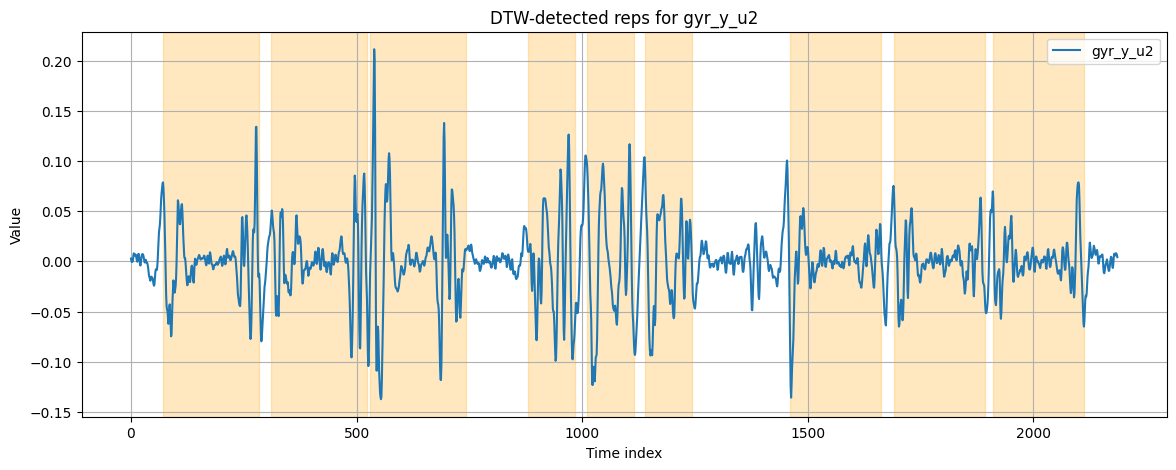

In [ ]:
import matplotlib.pyplot as plt

def plot_dtw_rep_bounds(group_df, final_bounds, sensor_cols, feature="gyr_x_u5"):
    """
    group_df: full subject-exercise dataframe
    final_bounds: list of (start, end) from DTW
    feature: which channel to visualize (string)
    """

    plt.figure(figsize=(14, 5))

    y = group_df[feature].values
    plt.plot(y, label=feature)

    # Draw DTW rep boundaries
    for (s, e) in final_bounds:
        plt.axvspan(s, e, alpha=0.25, color='orange')

    plt.title(f"DTW-detected reps for {feature}")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()


# Example
# Convert merged_bounds DataFrame to list of (start,end) tuples
rep_bounds = list(zip(yes['start'], yes['end']))

# Now call the plot function
plot_dtw_rep_bounds(group, rep_bounds, sensor_cols, feature="gyr_y_u2")


In [ ]:
def mtmm_dtw_all(
    filtered_df,
    times_sorted,
    subject,
    exercise,
    template_dict,
    step=10,
    sensor_cols=None,
    score_thresh=None,
):
    """
    Runs MTMM-DTW classification on a given subject/exercise pair using
    precomputed template_dict (global multi-exercise template library).

    Returns: DataFrame of detected reps with scores.
    """

    # --------------------------
    # 1. Extract group dataframe
    # --------------------------
    group = filtered_df[
        (filtered_df["subject"] == subject) &
        (filtered_df["exercise"] == exercise)
    ].reset_index(drop=True)

    if len(group) == 0:
        print(f"No samples found for {subject}, exercise {exercise}")
        return None

    # Default sensor cols
    if sensor_cols is None:
        sensor_cols = [c for c in group.columns 
                       if any(s in c for s in ["acc_", "gyr_", "mag_"])]

    # --------------------------
    # 2. Load rep template bounds
    # --------------------------
    bounds_df = collect_template_times(times_sorted, subject, f"e{exercise}")
    bounds = bounds_df.to_numpy()

    if len(bounds) == 0:
        print(f"No template times found for {subject} e{exercise}")
        return None

    # convert -> (start, end)
    rep_bounds_labeled = [
        (int(round(start)), int(round(end)))
        for (_, start, end) in bounds
    ]

    # --------------------------
    # 3. Select correct template set
    # --------------------------
    if exercise not in template_dict:
        print(f"No templates detected for exercise {exercise} in template_dict")
        return None

    exercise_templates = template_dict[exercise]

    # --------------------------
    # 4. Run MTMM DTW Pipeline
    # --------------------------
    result_df = mtmm_dtw_pipeline(
        group_df=group,
        rep_bounds_labeled=rep_bounds_labeled,
        sensor_cols=sensor_cols,
        template_dict=exercise_templates,   # templates for this exercise
        step=step,
        score_thresh=score_thresh,
    )

    return result_df

   start   end  source      score
0    265   422       1   3.455283
1    425   582       1  25.759560
2    600   660       1  29.257565
3    670   730       2   4.374913
4    740   800       1  29.731704
5    825   969       1  33.495293
6   1010  1154       3   3.869824
7   1165  1309       3  27.019335


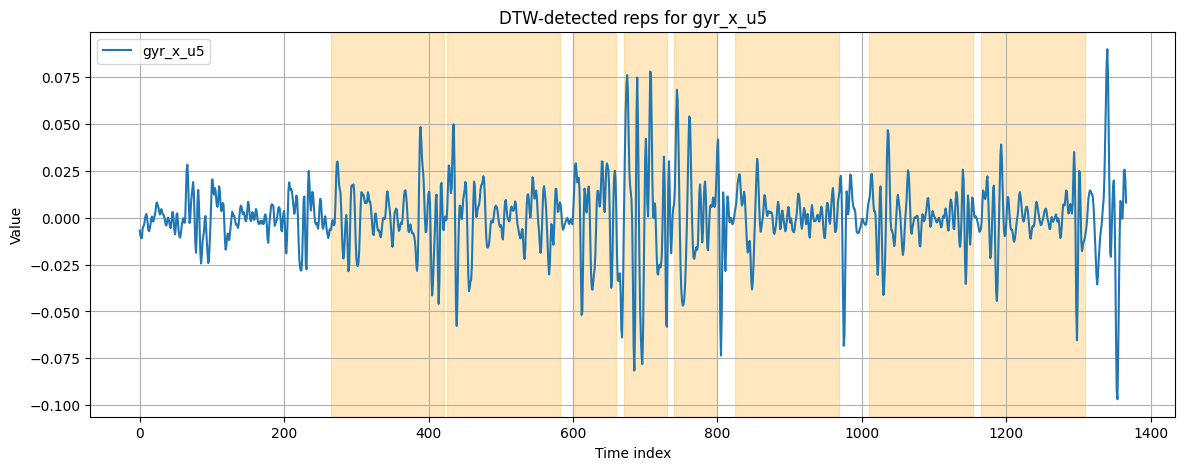

In [ ]:
sensor_cols = [c for c in filtered_df.columns 
               if any(s in c for s in ["acc_", "gyr_", "mag_"])]

subject = 's4'
exercise = 4

result = mtmm_dtw_all(
    filtered_df=filtered_df,
    times_sorted=times_sorted,
    subject=subject,
    exercise=exercise,
    template_dict=template_dict,
    step=5,
    sensor_cols=sensor_cols,
    score_thresh=36
)

print(result)

group = filtered_df[
        (filtered_df["subject"] == subject) &
        (filtered_df["exercise"] == exercise)
    ].reset_index(drop=True)

rep_bounds = list(zip(result['start'], result['end']))

plot_dtw_rep_bounds(group, rep_bounds, gyro_cols, "gyr_x_u5")

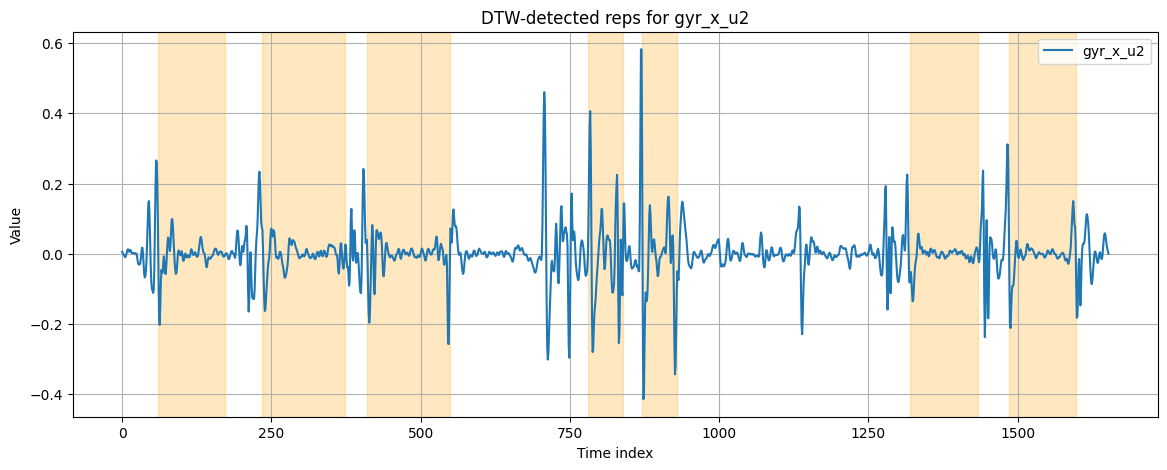

In [ ]:
acc_cols = [c for c in filtered_df.columns if any(s in c for s in ['acc_'])]

plot_dtw_rep_bounds(group, rep_bounds, gyro_cols, "gyr_x_u2")

You can use this pathname to see what each data point would look like

In [ ]:
all_intervals = []

for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        # Find corresponding timing CSV(s)
        sample_time_paths = times_sorted[
            (times_sorted['subject'] == subject) &
            (times_sorted['exercise'] == exercise)
        ]['path'].tolist()

        # Loop over all CSVs for this subject/exercise
        for path in sample_time_paths:
            sample_time = pd.read_csv(path, sep=";")

            # Convert to intervals list
            intervals = [
                (int(row['start']), int(row['end']), int(row['execution type']))
                for _, row in sample_time.iterrows()
            ]

            all_intervals.append({
                'subject': subject,
                'exercise': exercise,
                'intervals': intervals
            })

print(len(all_intervals))


TypeError: list indices must be integers or slices, not str

In [ ]:
all_intervals[0]

{'subject': 's1',
 'exercise': 'e1',
 'intervals': [(313, 528, 1), (1011, 1116, 2), (1688, 1891, 3)]}

In [ ]:
# sensor_files = templates DataFrame
# times_sorted_df = DataFrame with columns: subject, exercise, path

full_labeled_df, y = segment_series(
    all_results,
    window_size=50,
    stride=25,
    y_labels=all_results['active']
)
full_labeled_df.shape


(2212, 50, 70)

Rep Labeling and Identification Used here

In [ ]:
full_labeled_df[0]

array([[-9.665799, -1.677241, 0.615063, ..., 0, 's1', 'e1'],
       [-9.665806, -1.684737, 0.622513, ..., 0, 's1', 'e1'],
       [-9.62841, -1.699724, 0.585751, ..., 0, 's1', 'e1'],
       ...,
       [-9.658681, -1.655485, 0.60182, ..., 0, 's1', 'e1'],
       [-9.64375, -1.685436, 0.601991, ..., 0, 's1', 'e1'],
       [-9.643752, -1.670391, 0.572149, ..., 0, 's1', 'e1']],
      shape=(50, 70), dtype=object)

#### Activity Effect Graph

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_exercise(entry, sensor_prefix='acc', axis=['x', 'y', 'z'], unit=1,
                          show_active=True, show_execution=True, show_directional=False):
    """
    Plot sensor data and optional labels for a subject/exercise.

    Parameters
    ----------
    entry : dict
        One element from all_data or all_tests containing:
        'merged_df', 'subject', 'exercise', ...
    sensor_prefix : str
        Sensor to plot (default 'acc'). Can be 'gyr', 'mag', etc.
    axis : list
        Axes to plot (default ['x','y','z'])
    unit : int
        Unit number to plot (default 1)
    show_active : bool
        Whether to plot the 'active' column
    show_execution : bool
        Whether to plot the 'execution type' column
    show_directional : bool
        Whether to plot 'rep_up' and 'rep_down' columns instead of 'active'
    """
    df = entry['merged_df']
    subject = entry['subject']
    exercise = entry['exercise']

    plt.figure(figsize=(15,4))
    
    # Plot X, Y, Z for the chosen sensor/unit
    for ax in axis:
        col = f"{sensor_prefix}_{ax}_u{unit}"
        if col in df.columns:
            plt.plot(df[col], label=col)
    
    # Plot directional reps if requested
    if show_directional:
        if 'rep_start' in df.columns:
            plt.plot(df['rep_start'], label='rep_start', linewidth=3, color='g')
        if 'rep_end' in df.columns:
            plt.plot(df['rep_end'], label='rep_end', linewidth=3, color='r')
    # Otherwise, plot 'active' if present
    elif show_active and 'active' in df.columns:
        plt.plot(df['active'], label='active', linewidth=3)
    
    # Optional: plot 'execution type'
    if show_execution and 'execution type' in df.columns:
        plt.plot(df['execution type'], label='execution type', linestyle='--')
    
    plt.title(f"{sensor_prefix.upper()} signals of Subject {subject} performing Exercise {exercise}")
    plt.legend()
    plt.show()


In [ ]:
all_results[all_results['active'] == 1]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,gyr_mag_u4,gx_f_u5,gy_f_u5,gz_f_u5,gyr_mag_u5,active,rep_start,rep_end,subject,exercise
73,-9.666121,-1.625569,0.601775,-0.009411,0.004149,-0.004783,0.587197,0.454407,-0.092981,-9.499559,...,0.022917,-0.007417,-0.005353,-0.011454,0.014658,1,0,0,s1,e1
74,-9.636197,-1.640599,0.587298,-0.018443,-0.003976,-0.005731,0.587466,0.454278,-0.092970,-9.401637,...,0.020064,-0.006326,-0.005344,-0.007451,0.011140,1,1,0,s1,e1
75,-9.673715,-1.670249,0.571643,-0.022874,0.014803,-0.007387,0.588265,0.454943,-0.092825,-9.295975,...,0.017513,-0.011925,-0.003646,-0.009913,0.015930,1,0,0,s1,e1
76,-9.658733,-1.670320,0.571896,-0.004094,0.021437,0.007077,0.588994,0.455746,-0.093612,-9.346918,...,0.014985,-0.019097,-0.002010,-0.015522,0.024691,1,0,0,s1,e1
77,-9.643759,-1.670365,0.564678,-0.020300,0.009611,0.001604,0.587446,0.454937,-0.093116,-9.457866,...,0.016449,-0.020039,-0.002231,-0.017586,0.026755,1,0,0,s1,e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55290,-1.528093,-9.663237,-0.680984,0.041937,-0.010907,-0.004166,0.443920,0.599792,0.244584,-6.592511,...,0.155617,-0.016286,-0.009682,-0.008952,0.020955,1,0,0,s5,e8
55291,-1.542979,-9.625941,-0.643774,0.041127,-0.001159,-0.009521,0.443856,0.600762,0.242102,-8.327187,...,0.042888,0.000317,-0.005201,-0.006200,0.008099,1,0,0,s5,e8
55292,-1.542869,-9.588769,-0.591366,-0.005189,-0.002718,0.010480,0.443038,0.600482,0.242081,-9.074110,...,0.120291,0.007372,-0.005629,-0.003247,0.009827,1,0,0,s5,e8
55293,-1.527907,-9.588761,-0.613530,-0.018343,0.013761,-0.013805,0.444385,0.600634,0.241849,-8.162544,...,0.105255,0.005528,-0.010402,0.000324,0.011784,1,0,0,s5,e8


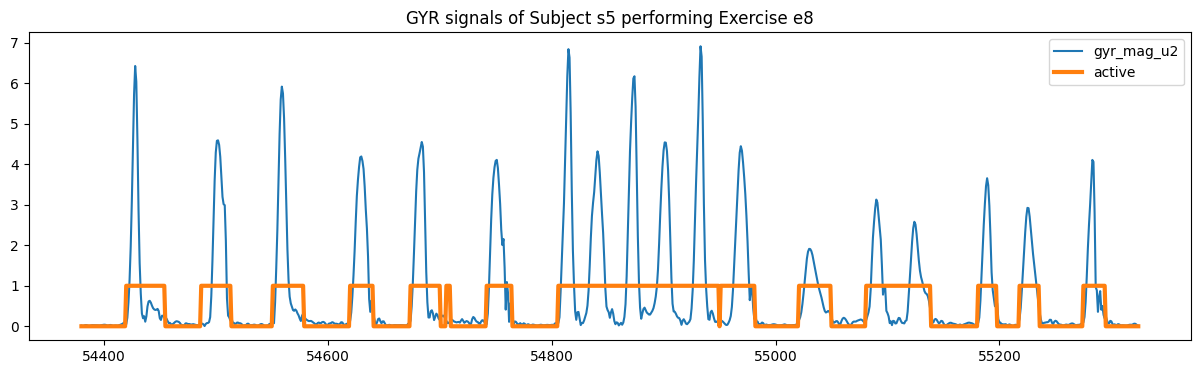

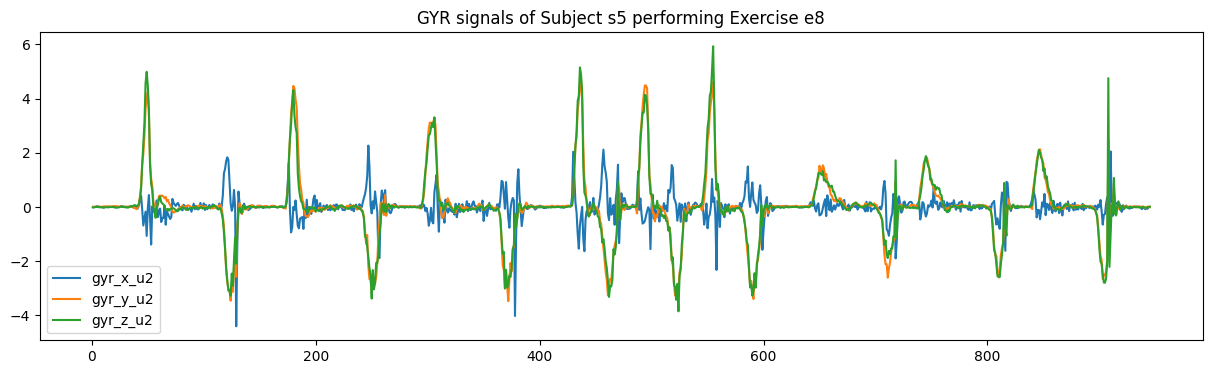

In [ ]:
subject = 's5'
exercise = 'e8'
unit = 2
mag_axis = ['mag'] # only for acc 
raw_axis = ['x', 'y', 'z']

plot_df2 = load_and_merge_sensors(templates, subject, exercise)

# Extract a single subject/exercise
plot_df = all_results[
    (all_results['subject'] == subject) &
    (all_results['exercise'] == exercise)
]

plot_subject_exercise({'merged_df': plot_df, 'subject':subject,'exercise':exercise}, axis=mag_axis, sensor_prefix='gyr', unit=unit)

plot_subject_exercise({'merged_df': plot_df2, 'subject':subject,'exercise':exercise}, axis=raw_axis, sensor_prefix='gyr', unit=unit, show_active=False, show_execution=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_reps(entry, full_reps, sensor_prefix='acc', axis=['x', 'y', 'z'], unit=1, show_active=True, show_execution=True):
    """
    Plot sensor data and overlay rep windows for a subject/exercise, 
    clipped to the DataFrame's timestep range.

    Parameters
    ----------
    entry : dict
        One element from all_data or all_tests containing:
        'merged_df', 'subject', 'exercise', ...
    full_reps : list of tuples
        List of (start, end) indices representing full rep windows.
    sensor_prefix : str
        Sensor to plot (default 'acc'). Can be 'gyr', 'mag', etc.
    axis : list
        List of axes to plot, e.g., ['x','y','z'].
    unit : int
        Unit number to plot (default 1)
    show_active : bool
        Whether to plot the 'active' column
    show_execution : bool
        Whether to plot the 'execution type' column
    """
    df = entry['merged_df']
    subject = entry['subject']
    exercise = entry['exercise']

    plt.figure(figsize=(15, 4))

    # Plot sensor channels
    for ax in axis:
        col = f"{sensor_prefix}_{ax}_u{unit}"
        if col in df.columns:
            plt.plot(df[col], label=col)

    # Optional: plot 'active'
    if show_active and 'active' in df.columns:
        plt.plot(df['active'], label='active', linewidth=2, alpha=0.7)
    
    # Optional: plot 'execution type'
    if show_execution and 'execution type' in df.columns:
        plt.plot(df['execution type'], label='execution type', linestyle='--', alpha=0.7)

    # Get current dataframe index range
    t_start = df.index.min()
    t_end = df.index.max()

    # Overlay full rep windows (clipped to df range)
    for start, end in full_reps:
        if end >= t_start and start <= t_end:
            plot_start = max(start, t_start)
            plot_end = min(end, t_end)
            plt.axvspan(plot_start, plot_end, color='red', alpha=0.3)

    plt.title(f"{sensor_prefix.upper()} signals of Subject {subject} performing Exercise {exercise}")
    plt.xlabel('Time Step')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()


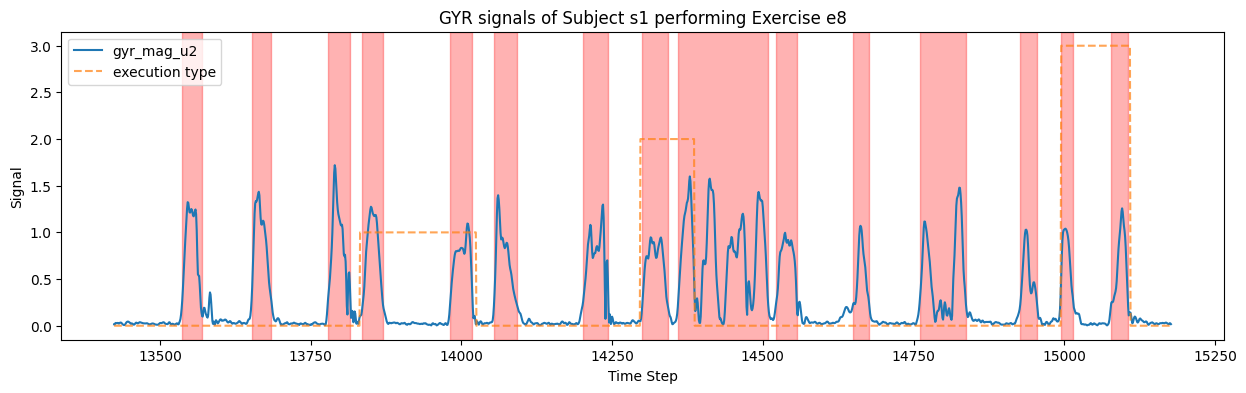

In [ ]:
full_reps = rep_bounds

# Suppose you already have:
# plot_df  -> your DataFrame
# subject  -> subject ID
# exercise -> exercise name
# full_reps -> list of tuples like [(76, 285), (318, 524), ...]

plot_subject_reps(
    entry={'merged_df': plot_df, 'subject': subject, 'exercise': exercise},
    full_reps=full_reps,          # <- here is your rep windows
    axis=mag_axis,                # e.g., ['x','y','z']
    sensor_prefix='gyr',          # e.g., 'acc', 'gyr', 'mag'
    unit=2,                    # e.g., 1
    show_active=True,
    show_execution=True
)


## Sample Training

### Activity Classifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_active, test_size=0.2, random_state=42, stratify=y_all_active
)

NameError: name 'X_all' is not defined

In [ ]:
X_train.shape, y_train.shape

((1724, 50, 51), (1724,))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

num_classes = len(np.unique(y_activity))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

NameError: name 'y_activity' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)   # e.g. [0,1]
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(enumerate(cw))

model.fit(X_train, y_train, epochs=20, batch_size=64,
          validation_data=(X_val, y_val),
          class_weight=class_weight)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3498 - loss: 0.6470 - val_accuracy: 0.6265 - val_loss: 0.6647
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6421 - loss: 0.5532 - val_accuracy: 0.8260 - val_loss: 0.5751
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8933 - loss: 0.4213 - val_accuracy: 0.9049 - val_loss: 0.4384
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9217 - loss: 0.3057 - val_accuracy: 0.9049 - val_loss: 0.3649
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9287 - loss: 0.2006 - val_accuracy: 0.9142 - val_loss: 0.2700
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9414 - loss: 0.1456 - val_accuracy: 0.9304 - val_loss: 0.2106
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9495 - loss: 0.1158 - val_accuracy: 0.9513 - val_loss: 0.1594
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9698 - loss: 0.0777 - val_accuracy: 0.9559 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


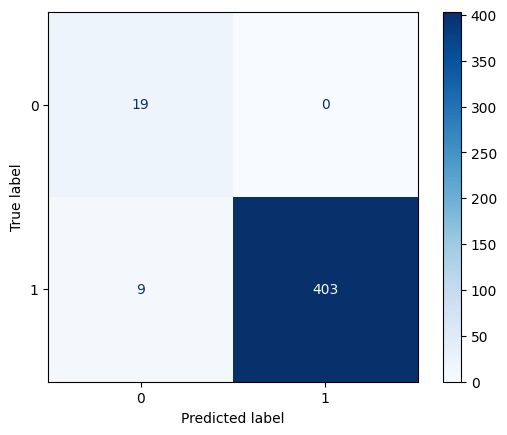

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

### Exercise Classifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_seg, y_exercise, test_size=0.2, random_state=42, stratify=y_exercise
)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1724, 50, 180), (1724,), (431, 50, 180), (431,))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(np.unique(y_exercise))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 256)            │       316,416 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,472 (1.21 MB)

 Trainable params: 318,472 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X_train,
    y_train,  # Convert one-hot to class indices
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9426 - loss: 0.2452 - val_accuracy: 0.9954 - val_loss: 0.0166
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9977 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9971 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9948 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 1.0000 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


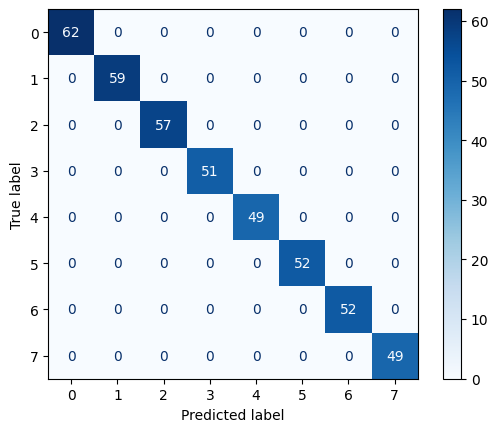

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [ ]:
test_dfs

array([[0.008569258382720907, -0.0030380574937521315,
        0.0002378392119200082, ..., -1.961089211871579e-05, 's1', 'e1'],
       [0.005601743385390416, 0.009969512908649643, 0.011859418088261965,
        ..., 0.00014590757377114043, 's1', 'e1'],
       [0.004978492609254668, 0.016611512374203833, 0.009740225275236523,
        ..., 4.500925055298497e-05, 's1', 'e1'],
       ...,
       [-0.017965662392538877, 0.011059689728692331,
        -0.0014136966218730015, ..., -0.0015718344922227717, 's5', 'e8'],
       [-0.01404308275201831, 0.009457692544242354,
        0.0001493526596608903, ..., -0.001231027860563367, 's5', 'e8'],
       [-0.0017594616669490974, 0.007885742682947457,
        0.013003130554945824, ..., -0.0005759018515799218, 's5', 'e8']],
      shape=(220278, 47), dtype=object)

In [ ]:
test_dfs = []
for subject in tests['subject'].unique():
    for exercise in tests['exercise'].unique():
        df = load_and_merge_sensors(tests, subject, exercise)
        test_filter = preprocess_sensor_data(df)
        test_dfs.append(test_filter)

test_dfs = pd.concat(test_dfs)

sensor_cols = [col for col in test_dfs.columns if any(sensor in col for sensor in ['acc_', 'gyr_', 'mag_'])]

test_segments_list = []
y_test_segments_list = []

label_map = {
    'e1': 1,
    'e2': 2,
    'e3': 3,
    'e4': 4,
    'e5': 5,
    'e6': 6,
    'e7': 7,
    'e8': 8
}

test_dfs['exercise'] = test_dfs['exercise'].map(label_map)

test_segments_list = []
y_test_segments_list = []
test_subject_windows_list = []

for (subject, exercise), group in test_dfs.groupby(['subject', 'exercise']):
    X = group[sensor_cols].values
    y_labels = group['exercise'].values  # numeric labels now

    X_windows, y_windows = segment_series(X, window_size=50, stride=25, y_labels=y_labels)
    test_segments_list.append(X_windows)
    y_test_segments_list.append(y_windows)
    
    # Keep track of subject for each window
    test_subject_windows_list.append(np.array([subject]*len(X_windows)))

# Combine all
test_segments = np.concatenate(X_segments_list, axis=0)
y_test_segments = np.concatenate(y_segments_list, axis=0)
test_subject_windows = np.concatenate(test_subject_windows_list, axis=0)  # NEW

## Data Export

Run everything in the ipynb and finish here

In [ ]:
import pickle

train_dict = {
    'X_seg': X_windows_scaled,
    'y_exercise': y_segments,
    'subject_windows':subject_windows
}

test_dict = {
    'X_test': test_segments,
    'y_test_exercise': y_test_segments,
    'subject_test_windows': test_subject_windows
}

with open('../data/training.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)